In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time
from keras.wrappers.scikit_learn import KerasClassifier
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os            ##  This module is for "operating system" interfaces
import sys           ##  This module is for functionality relevant to the python run time

GOOGLE_PATH_AFTER_MYDRIVE = 'NLP_Textcat/spooky_data/train'
GOOGLE_DRIVE_PATH = os.path.join('drive','My Drive', GOOGLE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Append the directory path of this notebook to what python easily "sees"
sys.path.append(GOOGLE_DRIVE_PATH)

# Make your current working direct
GOOGLE_DRIVE_PATH

['train.csv']


'drive/My Drive/NLP_Textcat/spooky_data/train'

In [5]:
df = pd.read_csv('drive/My Drive/NLP_Textcat/spooky_data/train/train.csv')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [6]:
X = df["text"].copy()
#X = df["text"]

authors = df["author"].copy()

# Label data
y = []
for author in authors:
    if author == "EAP":
        y.append([1, 0, 0])
    if author == "HPL":
        y.append([0, 1, 0])
    if author == "MWS":
        y.append([0, 0, 1])

y = np.array(y)

y_one_vector = []
for author in authors:
    if author == "EAP":
        y_one_vector.append(0)
    if author == "HPL":
        y_one_vector.append(1)
    if author == "MWS":
        y_one_vector.append(2)

y_one_vector = np.array(y_one_vector)

In [7]:
encoder = tf.keras.layers.TextVectorization()
encoder.adapt(X)
vocab = encoder.get_vocabulary()


In [23]:
def create_model(embed_dim=64,num_layer = 1,lstm_units=64,dropout_rate = 0.2, lstm_dr = 0.2):
#def create_model():

  # create model

  LSTM = tf.keras.Sequential()
  LSTM.add(encoder)
  LSTM.add(tf.keras.layers.Embedding(input_dim=len(vocab),output_dim=embed_dim,mask_zero=True))

  for n in range(num_layer):
      LSTM.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units,dropout=lstm_dr,return_sequences=True)))

  LSTM.add(tf.keras.layers.GlobalMaxPool1D())
  LSTM.add(tf.keras.layers.Dropout(dropout_rate))

  LSTM.add(tf.keras.layers.Dense(3, activation='softmax'))

  LSTM.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(1e-3),
                metrics=['accuracy'])
  return LSTM

In [29]:
#from scikeras.wrappers import KerasClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset

# create model
model = KerasClassifier(build_fn=create_model, batch_size=64, verbose=1)
# define the grid search parameters
embed_dim = [32,64,128,256]
num_layer = [1,2,3]
lstm_units =  [32,64,128,256]
dropout_rate = [0.0,0.1,0.2,0.3]
epochs = [1,2]
lstm_dr = [0.0,0.1,0.2,0.3]

param_grid = dict(embed_dim=embed_dim,num_layer = num_layer,lstm_units = lstm_units,
                  dropout_rate = dropout_rate, epochs=epochs,lstm_dr = lstm_dr)
#grid = GridSearchCV(estimator=model, scoring = 'neg_log_loss', param_grid=param_grid, n_jobs=1, cv=3, verbose=3)
grid = RandomizedSearchCV(model, param_grid, n_iter=10,scoring = 'neg_log_loss', n_jobs=1, cv=3, verbose=3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  # Remove the CWD from sys.path while we load stuff.


In [30]:
start_time = time.time()
grid_result = grid.fit(X, y)
stop_time = time.time()

# summarize results
print('time search took:', stop_time - start_time)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] num_layer=2, lstm_units=128, lstm_dr=0.2, epochs=2, embed_dim=64, dropout_rate=0.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/2
204/204 [==============================] - 45s 125ms/step - loss: 0.7023 - accuracy: 0.6885
Epoch 2/2
204/204 [==============================] - 23s 115ms/step - loss: 0.2502 - accuracy: 0.9090
[CV]  num_layer=2, lstm_units=128, lstm_dr=0.2, epochs=2, embed_dim=64, dropout_rate=0.0, score=-0.449, total= 1.4min
[CV] num_layer=2, lstm_units=128, lstm_dr=0.2, epochs=2, embed_dim=64, dropout_rate=0.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


Epoch 1/2
204/204 [==============================] - 47s 133ms/step - loss: 0.6984 - accuracy: 0.6902
Epoch 2/2
204/204 [==============================] - 27s 130ms/step - loss: 0.2592 - accuracy: 0.9039
[CV]  num_layer=2, lstm_units=128, lstm_dr=0.2, epochs=2, embed_dim=64, dropout_rate=0.0, score=-0.472, total= 2.0min
[CV] num_layer=2, lstm_units=128, lstm_dr=0.2, epochs=2, embed_dim=64, dropout_rate=0.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s


Epoch 1/2
204/204 [==============================] - 45s 125ms/step - loss: 0.7045 - accuracy: 0.6892
Epoch 2/2
204/204 [==============================] - 25s 125ms/step - loss: 0.2502 - accuracy: 0.9098
[CV]  num_layer=2, lstm_units=128, lstm_dr=0.2, epochs=2, embed_dim=64, dropout_rate=0.0, score=-0.473, total= 2.0min
[CV] num_layer=3, lstm_units=128, lstm_dr=0.1, epochs=2, embed_dim=32, dropout_rate=0.3 
Epoch 1/2
204/204 [==============================] - 67s 183ms/step - loss: 0.7391 - accuracy: 0.6689
Epoch 2/2
204/204 [==============================] - 33s 160ms/step - loss: 0.2747 - accuracy: 0.8986
[CV]  num_layer=3, lstm_units=128, lstm_dr=0.1, epochs=2, embed_dim=32, dropout_rate=0.3, score=-0.488, total= 2.1min
[CV] num_layer=3, lstm_units=128, lstm_dr=0.1, epochs=2, embed_dim=32, dropout_rate=0.3 
Epoch 1/2
204/204 [==============================] - 66s 178ms/step - loss: 0.7815 - accuracy: 0.6451
Epoch 2/2
204/204 [==============================] - 35s 171ms/step - loss: 

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 40.7min finished


Epoch 1/2
306/306 [==============================] - 33s 75ms/step - loss: 0.7053 - accuracy: 0.6931
Epoch 2/2
306/306 [==============================] - 22s 71ms/step - loss: 0.2639 - accuracy: 0.9016
time search took: 2532.2571194171906


In [31]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.449755 using {'num_layer': 1, 'lstm_units': 256, 'lstm_dr': 0.0, 'epochs': 2, 'embed_dim': 64, 'dropout_rate': 0.1}


In [32]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

In [ ]:
l = create_model()

In [13]:
with tf.device('/CPU:0'):
    l = create_model()
    l.fit(X, y, epochs = 2)

Epoch 1/2
612/612 [==============================] - 114s 170ms/step - loss: 0.6539 - accuracy: 0.7216
Epoch 2/2
612/612 [==============================] - 104s 170ms/step - loss: 0.2613 - accuracy: 0.9027


In [14]:
with tf.device('/GPU:0'):
    l = create_model()
    l.fit(X, y, epochs = 2)

Epoch 1/2
612/612 [==============================] - 42s 51ms/step - loss: 0.6440 - accuracy: 0.7232
Epoch 2/2
612/612 [==============================] - 31s 51ms/step - loss: 0.2573 - accuracy: 0.9052


In [15]:
l = create_model()
l.fit(X, y, epochs = 2)

Epoch 1/2
612/612 [==============================] - 40s 50ms/step - loss: 0.6670 - accuracy: 0.7103
Epoch 2/2
612/612 [==============================] - 31s 50ms/step - loss: 0.2754 - accuracy: 0.8977


In [34]:
d=pd.DataFrame(params)
d['Mean']=means
d['Std. Dev']=stds
d

,num_layer,lstm_units,lstm_dr,epochs,embed_dim,dropout_rate,Mean,Std. Dev
0,2,128,0.2,2,64,0.0,-0.464781,0.010916
1,3,128,0.1,2,32,0.3,-0.484512,0.013051
2,1,256,0.0,2,64,0.1,-0.449755,0.002365
3,2,256,0.1,1,64,0.1,-0.487809,0.029258
4,2,128,0.1,1,128,0.0,-0.463774,0.002373
5,2,128,0.0,2,64,0.2,-0.485108,0.007671
6,2,64,0.2,1,128,0.3,-0.477612,0.016389
7,1,256,0.0,2,32,0.3,-0.463497,0.009613
8,1,128,0.2,2,128,0.3,-0.453495,0.012142
9,2,128,0.0,2,64,0.1,-0.500542,0.011637


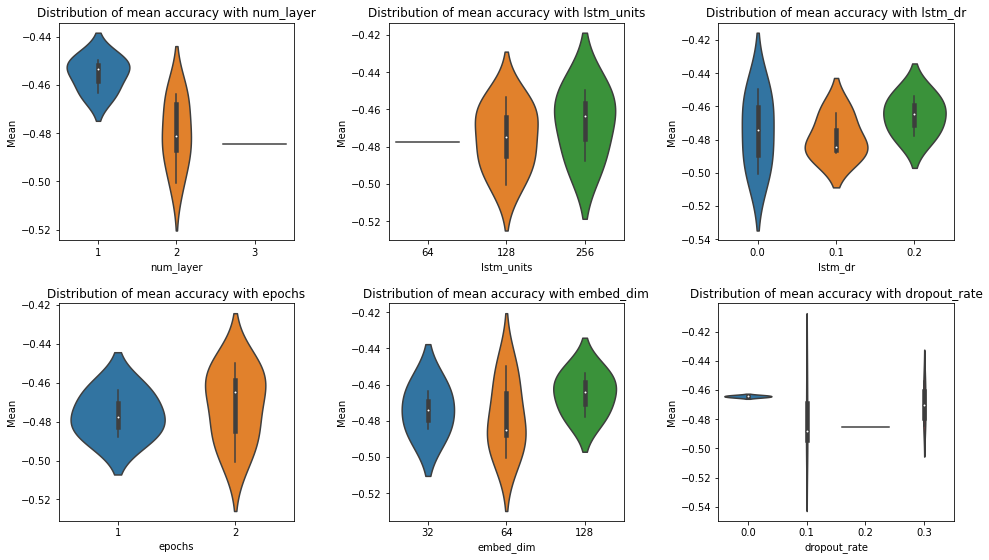

In [36]:
param_ = ["num_layer","lstm_units","lstm_dr","epochs","embed_dim","dropout_rate"]
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,3,figsize=(14,8), squeeze=False)
ax = ax.ravel()
for i in range(6):
    ax[i].set_title('Distribution of mean accuracy with {}'.format(param_[i]))
    sns.violinplot(x=param_[i],y='Mean',data=d,ax=ax[i])
fig.tight_layout(pad=1.5)

In [37]:
d.sort_values(by='Mean',ascending = False)

,num_layer,lstm_units,lstm_dr,epochs,embed_dim,dropout_rate,Mean,Std. Dev
2,1,256,0.0,2,64,0.1,-0.449755,0.002365
8,1,128,0.2,2,128,0.3,-0.453495,0.012142
7,1,256,0.0,2,32,0.3,-0.463497,0.009613
4,2,128,0.1,1,128,0.0,-0.463774,0.002373
0,2,128,0.2,2,64,0.0,-0.464781,0.010916
6,2,64,0.2,1,128,0.3,-0.477612,0.016389
1,3,128,0.1,2,32,0.3,-0.484512,0.013051
5,2,128,0.0,2,64,0.2,-0.485108,0.007671
3,2,256,0.1,1,64,0.1,-0.487809,0.029258
9,2,128,0.0,2,64,0.1,-0.500542,0.011637
